In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt
import plotly.express as px
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from sklearn.metrics import mean_absolute_error as mae 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

np.random.seed(234)
tf.random.set_seed(234)

In [5]:
##https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
##https://www.kaggle.com/code/calven22/forecasting-inflation-with-arima-and-lstm

In [24]:
dataset = pd.read_csv('InflationData.csv')
values = dataset.values
data = dataset.loc[:, dataset.columns != 'DATE']
data

,OIL,PersonalExpenditure,RealDisposableIncome,M2REAL,Unemployment,InterestRate,FoodIndex
0,13.900,306.1,2318.4,987.9,6.0,2.48,29.800
1,13.900,309.6,2325.4,992.1,5.9,2.43,29.700
2,14.000,312.7,2338.7,998.3,5.6,2.80,29.500
3,14.000,312.2,2353.8,1001.0,5.2,2.96,29.500
4,14.000,316.1,2366.6,1006.2,5.1,2.90,29.500
...,...,...,...,...,...,...,...
777,396.278,18826.8,16847.8,6730.6,3.8,5.33,325.731
778,392.414,18903.0,16912.1,6728.3,3.7,5.33,325.172
779,382.583,19013.7,16946.5,6732.5,3.7,5.33,325.409
780,373.663,19043.6,16946.7,6713.3,3.7,5.33,327.327


In [25]:
data = data.drop(columns=['OIL','RealDisposableIncome','M2REAL','PersonalExpenditure'])
data

,Unemployment,InterestRate,FoodIndex
0,6.0,2.48,29.800
1,5.9,2.43,29.700
2,5.6,2.80,29.500
3,5.2,2.96,29.500
4,5.1,2.90,29.500
...,...,...,...
777,3.8,5.33,325.731
778,3.7,5.33,325.172
779,3.7,5.33,325.409
780,3.7,5.33,327.327


In [26]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset


# ensure all data is float

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(data)
# frame as supervised learning


reframed = series_to_supervised(scaled, 1, 1)
reframed

,var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
1,0.228070,0.127559,0.001341,0.219298,0.124934,0.001006
2,0.219298,0.124934,0.001006,0.192982,0.144357,0.000335
3,0.192982,0.144357,0.000335,0.157895,0.152756,0.000335
4,0.157895,0.152756,0.000335,0.149123,0.149606,0.000335
5,0.149123,0.149606,0.000335,0.140351,0.175328,0.001341
...,...,...,...,...,...,...
777,0.035088,0.277165,0.989854,0.035088,0.277165,0.993296
778,0.035088,0.277165,0.993296,0.026316,0.277165,0.991422
779,0.026316,0.277165,0.991422,0.026316,0.277165,0.992217
780,0.026316,0.277165,0.992217,0.026316,0.277165,0.998646


In [27]:
reframed.drop(reframed.columns[[3,4]], axis=1, inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var3(t)
1,0.228070,0.127559,0.001341,0.001006
2,0.219298,0.124934,0.001006,0.000335
3,0.192982,0.144357,0.000335,0.000335
4,0.157895,0.152756,0.000335,0.000335
5,0.149123,0.149606,0.000335,0.001341


In [28]:
n_train_hours = int(len(values) *0.8)
print(len(values)-n_train_hours)

157


In [29]:

# split into train and test sets
values = reframed.values
n_train_hours = int(len(values) *0.8)

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 


(624, 1, 3) (624,) (157, 1, 3) (157,)


In [30]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


 

Epoch 1/70
9/9 - 1s - 119ms/step - loss: 0.2441 - val_loss: 0.7666
Epoch 2/70
9/9 - 0s - 6ms/step - loss: 0.2131 - val_loss: 0.7137
Epoch 3/70
9/9 - 0s - 5ms/step - loss: 0.1920 - val_loss: 0.6661
Epoch 4/70
9/9 - 0s - 5ms/step - loss: 0.1773 - val_loss: 0.6226
Epoch 5/70
9/9 - 0s - 5ms/step - loss: 0.1686 - val_loss: 0.5853
Epoch 6/70
9/9 - 0s - 5ms/step - loss: 0.1631 - val_loss: 0.5527
Epoch 7/70
9/9 - 0s - 5ms/step - loss: 0.1584 - val_loss: 0.5235
Epoch 8/70
9/9 - 0s - 6ms/step - loss: 0.1527 - val_loss: 0.4957
Epoch 9/70
9/9 - 0s - 6ms/step - loss: 0.1455 - val_loss: 0.4689
Epoch 10/70
9/9 - 0s - 5ms/step - loss: 0.1420 - val_loss: 0.4426
Epoch 11/70
9/9 - 0s - 6ms/step - loss: 0.1352 - val_loss: 0.4174
Epoch 12/70
9/9 - 0s - 5ms/step - loss: 0.1279 - val_loss: 0.3913
Epoch 13/70
9/9 - 0s - 5ms/step - loss: 0.1232 - val_loss: 0.3656
Epoch 14/70
9/9 - 0s - 5ms/step - loss: 0.1163 - val_loss: 0.3405
Epoch 15/70
9/9 - 0s - 5ms/step - loss: 0.1103 - val_loss: 0.3153
Epoch 16/70
9/9 -

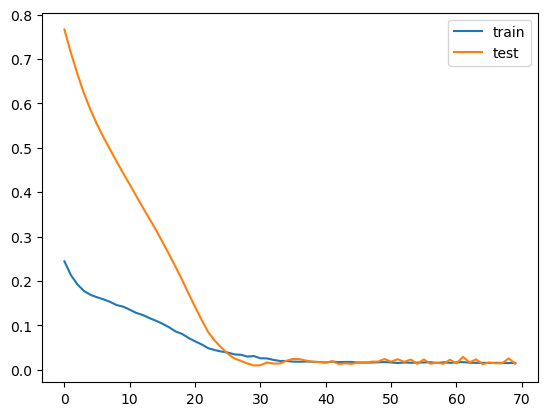

In [31]:
history = model.fit(train_X, train_y, epochs=70, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [32]:
n_features=3
def feature_importance(model, g):
    random_ind = np.random.choice(g.shape[0], 100, replace=False) # Randomly generate 100 numbers arange(218) 
    x = g[random_ind] #  Take 100 random sample from training set
    orig_out = model.predict(x)
    for i in range(n_features):  # iterate over the 7 features
        new_x = x.copy()
        perturbation_in = np.random.normal(0.0, 0.7, size=new_x.shape[:2]) # Draw random samples from normal distribution with sd = 0.7, this value is arbitary and would not affect the order of effect as its just introducing noise.
        new_x[:, :, i] = new_x[:, :, i] + perturbation_in
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        print(f'Variable {i+1}, Perturbation Effect: {effect:.3f}')
        
feature_importance(model,train_X)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step
Variable 1, Perturbation Effect: 0.014
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step
Variable 2, Perturbation Effect: 0.016
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step
Variable 3, Perturbation Effect: 0.655


In [33]:
# calculate RMSE
yhat = model.predict(test_X)
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)
error = mae(test_y, yhat) 
  
# display 
print("Mean absolute error : " + str(error)) 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step
Test RMSE: 0.011
Mean absolute error : 0.0057494231154826495


In [34]:
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast


In [35]:
data.shape
inv_yhat = concatenate((test_X[:, 0:2],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)


# invert caling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, 0:2],test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, -1:]
inv_yhat = inv_yhat[:, -1:]

(782, 3)

In [36]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
error = mae(inv_y, inv_yhat) 
  
# display 
print("Mean absolute error : " + str(error)) 

Test RMSE: 3.246
Mean absolute error : 1.7152311474650492


In [37]:
startDate = int(len(values) *0.8)+1
dates = dataset['DATE'][startDate:]
dates

625     2/1/11
626     3/1/11
627     4/1/11
628     5/1/11
629     6/1/11
        ...   
777    10/1/23
778    11/1/23
779    12/1/23
780     1/1/24
781     2/1/24
Name: DATE, Length: 157, dtype: object

In [38]:
date = pd.date_range('2/1/2011', periods=len(dates), freq='m')

Text(0.5, 1.0, 'True vs Predicted Food Inflation (Food Index t-1)')

Text(0.5, 0, 'Dates')

Text(0, 0.5, 'Food Index')

(array([14610., 15340., 16071., 16801., 17532., 18262., 18993., 19723.]),
 [Text(14610.0, 0, '2010'),
  Text(15340.0, 0, '2012'),
  Text(16071.0, 0, '2014'),
  Text(16801.0, 0, '2016'),
  Text(17532.0, 0, '2018'),
  Text(18262.0, 0, '2020'),
  Text(18993.0, 0, '2022'),
  Text(19723.0, 0, '2024')])

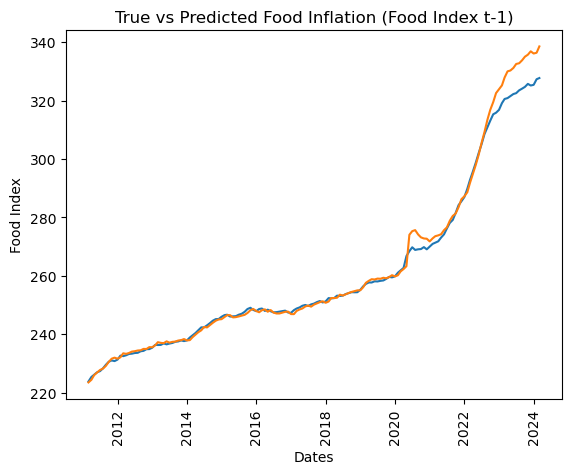

In [39]:
plt.plot(date, inv_y)
plt.plot(date, inv_yhat)
plt.title("True vs Predicted Food Inflation (Food Index t-1)")
plt.xlabel("Dates")
plt.ylabel("Food Index")
plt.xticks(rotation='vertical')


In [40]:
df = pd.DataFrame()
df['date'] = dates
df['inv_y'] = inv_y
df['inv_yhat'] = inv_yhat
df.to_csv("FoodInflationPred_FI_IR_UE.csv")
model.save("InflationLSTM_FI_IR_UE.keras")